# Label data demo

> **Note**: If you wish to save this notebook with any of your changes, please make sure to click on `File` -> `Save a copy in Drive`. All changes will be lost if you close this tab without saving a copy in your Google Drive. All changes made before saving a copy in Drive will be saved in the notebook after you save a copy in Drive. Data is downloaded from the internet and stored in the temporary disk of the environment. This data will be deleted once the session is over.

This Jupyter notebook intended to demonstrate practical preparation of label data for use in MOSAIKS. The notebook will guide you through the process of preparing a dataset for use in MOSAIKS, including:

1. Building and using a MOSAIKS standardized grid

1. Preparing geographic point labels (latitude and longitude coordinates)

1. Preparing geographic line labels (e.g. shapefiles)

1. Preparing geographic polygon labels (e.g. shapefiles)

1. Preparing raster labels (e.g. GeoTIFFs)

This notebook will not cover the modeling process. Modeling will be covered in later chapters of the training manual and in notebooks dedicated to it.

## Environment setup

### Install required packages

Google Colab is a free Jupyter notebook environment that requires no setup and runs entirely in the cloud. It comes preinstalled with many packages, including most of the ones we need for this notebook. There are a few additional packages we need to install, which we will do in the next cell.


In [40]:
!pip install rasterio
!pip install exactextract
!pip install mapclassify

### Load required packages

Now that we have all of the packages we need, we can load all the ones we will use in this notebook.


In [41]:
import os
import rasterio
import subprocess
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio.features
import matplotlib.pyplot as plt

from rasterio.mask import mask
from rasterio.merge import merge
from rasterio.io import MemoryFile
from exactextract import exact_extract
from matplotlib.patches import Rectangle
from shapely.geometry import box, Polygon, MultiPolygon, GeometryCollection

## MOSAIKS grid

The standard resolution of MOSAIKS is a global grid at 0.01° resolution. Each grid cell is approximately 1 km² at the equator. The grid is often represented as a point grid, where each point is the center of a grid cell. This means that standard MOSAIKS features come with a latitude and longitude coordinate, which is the center of the grid cell.

Here we show several ways to create a MOSAIKS grid for a given location.

> It is important to note that the grid is standardised such that the grid cells are centered at intervals of 0.005 degrees (e.g., 10.005, 10.015, 10.025,...).

There is no firm reason why this resolution was chosen, but it is a good compromise between resolution and computational efficiency. If a user is computing customized features for their application, they can choose a different resolution. However, it is important to note that the resolution of the grid will affect the computation time and the amount of data that needs to be stored.

### Advantages of the MOSAIKS grid

The MOSAIKS grid has several advantages, but the promary advantage is that it helps avoid overlapping labels. Often data labels come with coordinates which are not standardly spaced. If you are forced to align your labels to a grid, you can avoid bleed over from one label to another. This is especially important when you are working with data that has a high degree of spatial autocorrelation.

### Create a function to create a grid

The following code creates a function that will create a standard MOSAIKS grid for a given location. The location can be given as a bounding box of the format `[minx, miny, maxx, maxy]`, a `shapely.geometry.polygon`, or a `geopandas.GeoDataFrame` with a geometry column containing polygons.

- If a bounding box is given, the grid will be created for the bounding box

- If a `shapely.geometry.polygon` is given, the grid will be created for the bounding box of the polygon, and then cropped to the polygon

- If a `geopandas.GeoDataFrame` is given, the grid will be created for the bounding box of each row, and then cropped to the geometry of that row


In [42]:
def create_grid(
    borders,
    resolution: float = 0.01,
    geometry_col: str = "geometry",
    id_col: str = "NAME",
    return_ids: bool = False,
) -> pd.DataFrame:
    """
    Create a grid of latitude and longitude coordinates for one or more geometries.
    It can accept a bounding box, a single polygon (or other Shapely geometry),
    or a GeoDataFrame with a geometry column.

    Parameters
    ----------
    borders : list or tuple or shapely.geometry.BaseGeometry or geopandas.GeoDataFrame
        - If list/tuple of length 4, interpreted as a bounding box: [minx, miny, maxx, maxy].
        - If a Shapely geometry (Polygon, MultiPolygon, etc.), creates a single-row GeoDataFrame.
        - If a GeoDataFrame, the function iterates over its rows.
    resolution : float, optional
        Grid resolution in degrees, default 0.01.
    geometry_col : str, optional
        Column name for the geometry in the resulting GeoDataFrame, by default "geometry".
    id_col : str, optional
        Column name in the GeoDataFrame to use as the ID column, or the name
        for the new column if bounding box / single polygon is provided. Default is "NAME".
    return_ids : bool, optional
        If True, generate and return the unique IDs for each grid cell. This will create a
        column 'unique_id' which follows the pattern 'lon_{lon}__lat_{lat}'. This option slows
        down the overall operation. Default is False.

    Returns
    -------
    pd.DataFrame
        A DataFrame with columns:
        - 'lat': latitude values (Y)
        - 'lon': longitude values (X)
        - `[id_col]`: the identifier for each geometry feature
        - 'unique_id': a string combining [id_col] + lon/lat for uniqueness (optional)
    """

    # 1. Convert input to a GeoDataFrame
    gdf = _to_geodataframe(borders, geometry_col, id_col)

    # 2. Ensure there's an ID column in the GeoDataFrame
    if id_col not in gdf.columns:
        # If user didn't provide an ID col for bounding box or single geometry,
        # assign a placeholder ID. For a multi-row GDF, user is expected to pass
        # an existing column name.
        gdf[id_col] = [f"feature_{i}" for i in range(len(gdf))]

    # 3. Rasterize each geometry and collect points
    result_list = []
    for _, row in gdf.iterrows():
        geom = row[geometry_col]
        this_id = row[id_col]

        if geom.is_empty:
            # Skip empty geometries
            continue

        minx, miny, maxx, maxy = geom.bounds

        # ---- Create arrays for lat and lon values (Note: lat reversed) ----
        # The 0.005 shift ensures that coordinates align on .005
        lats = np.arange(
            np.ceil(maxy / resolution) * resolution - 0.005, miny, -resolution
        )
        lons = np.arange(
            np.ceil(minx / resolution) * resolution + 0.005, maxx, resolution
        )

        if len(lats) == 0 or len(lons) == 0:
            # If bounding box is too small or resolution is large, might be empty
            continue

        # ---- Create a meshgrid ----
        lon_grid, lat_grid = np.meshgrid(lons, lats)

        # ---- Rasterize the geometry ----
        out_shape = (len(lats), len(lons))
        transform = rasterio.transform.from_bounds(
            minx, miny, maxx, maxy, out_shape[1], out_shape[0]
        )

        mask = rasterio.features.rasterize(
            [(geom, 1)],
            out_shape=out_shape,
            transform=transform,
            fill=0,
            dtype=np.uint8,
        )

        # ---- Extract the lat and lon values using the mask ----
        lat_values = lat_grid[mask == 1]
        lon_values = lon_grid[mask == 1]

        # ---- Create a DataFrame and append to the result list ----
        temp_df = pd.DataFrame({"lat": lat_values, "lon": lon_values})
        temp_df[id_col] = this_id
        result_list.append(temp_df)

    # 4. Concatenate the results
    if len(result_list) == 0:
        final_result = pd.DataFrame(columns=["lat", "lon", id_col, "unique_id"])
    else:
        final_result = pd.concat(result_list, ignore_index=True)
        if return_ids:
            # --- Create the unique_id column ---
            # e.g. 'lon_-10.005__lat_9.995'
            final_result["lon_rounded"] = final_result["lon"].round(3).astype(str)
            final_result["lat_rounded"] = final_result["lat"].round(3).astype(str)

            final_result["unique_id"] = (
                "lon_"
                + final_result["lon_rounded"]
                + "__lat_"
                + final_result["lat_rounded"]
            )

            final_result.drop(["lon_rounded", "lat_rounded"], axis=1, inplace=True)

    return final_result


def _to_geodataframe(borders, geometry_col: str, id_col: str) -> gpd.GeoDataFrame:
    """
    Internal helper that converts various input types into a standardized GeoDataFrame.

    Parameters
    ----------
    borders : list/tuple, shapely geometry, or GeoDataFrame
        Bounding box (list/tuple of length 4),
        single Shapely geometry (Polygon, MultiPolygon, etc.),
        or a GeoDataFrame.
    geometry_col : str
        The name of the geometry column to use or create.
    id_col : str
        The column in which to store or look for an ID (if relevant).

    Returns
    -------
    gpd.GeoDataFrame
        A GeoDataFrame with columns [id_col, geometry_col].
    """
    # Case 1: bounding box
    if isinstance(borders, (list, tuple)) and len(borders) == 4:
        minx, miny, maxx, maxy = borders
        geom = box(minx, miny, maxx, maxy)
        gdf = gpd.GeoDataFrame(
            {id_col: ["bbox_1"], geometry_col: [geom]}, crs="EPSG:4326"
        )

    # Case 2: single shapely geometry
    elif isinstance(borders, (Polygon, MultiPolygon, GeometryCollection)):
        gdf = gpd.GeoDataFrame(
            {id_col: ["geom_1"], geometry_col: [borders]}, crs="EPSG:4326"
        )

    # Case 3: GeoDataFrame
    elif isinstance(borders, gpd.GeoDataFrame):
        # If geometry_col does not exist, rename the current geometry column
        # so everything is consistent
        if geometry_col not in borders.columns:
            borders = borders.rename(columns={borders.geometry.name: geometry_col})

        gdf = borders.copy()
        gdf = gdf.set_geometry(geometry_col)

    else:
        raise ValueError(
            "Unsupported input for 'borders'. Must be one of:\n"
            "1) [minx, miny, maxx, maxy]\n"
            "2) A Shapely geometry (Polygon, MultiPolygon, etc.)\n"
            "3) A GeoDataFrame"
        )

    return gdf

### Create a grid for a bounding box

In the following example, we create a grid for an arbitrary bounding box.


In [43]:
# format[minx, miny, maxx, maxy]
bbox = [0.0, 0.0, 0.5, 0.5]
bbox_grid_df = create_grid(
    bbox,
    resolution=0.01,
    geometry_col="geometry",
    id_col="NAME",
    return_ids=True,
)
print(bbox_grid_df.head(), "\nShape: ", bbox_grid_df.shape)


     lat    lon    NAME             unique_id
0  0.495  0.005  bbox_1  lon_0.005__lat_0.495
1  0.495  0.015  bbox_1  lon_0.015__lat_0.495
2  0.495  0.025  bbox_1  lon_0.025__lat_0.495
3  0.495  0.035  bbox_1  lon_0.035__lat_0.495
4  0.495  0.045  bbox_1  lon_0.045__lat_0.495 
Shape:  (2500, 4)


#### Visualize the grid

Next we visualize the grid. To do this, we first create a GeoDataFrame with the grid points. We then buffer the points to create a polygon around each point. We use a `cap_style=3` to create square corners from the buffered points. Finally, we plot the grid points (green), the grid polygons (black), and the original bounding box (red).

**Note:** the following code produces a warning from the buffer operation. This is because the buffer operation is being conducted on geometry in a geographic CRS. This warning can be safely ignored in the context of MOSAIKS.


C:\Users\Cullen\AppData\Local\Temp\ipykernel_30100\2419158885.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  bbox_grid_gdf.geometry = bbox_grid_gdf.geometry.buffer(0.005, cap_style=3)


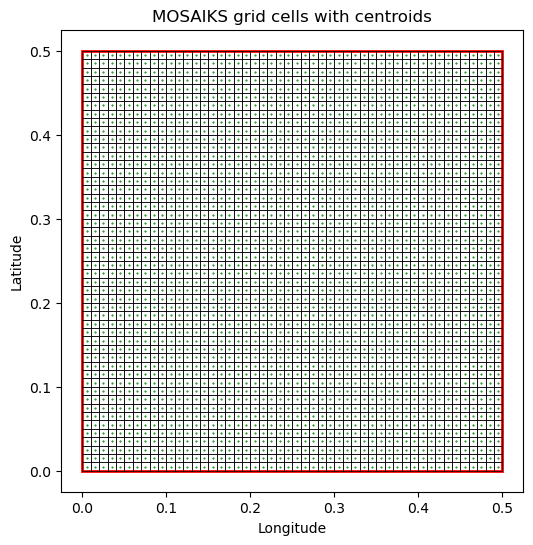

In [44]:
bbox_grid_gdf = gpd.GeoDataFrame(
    bbox_grid_df,
    geometry=gpd.points_from_xy(bbox_grid_df.lon, bbox_grid_df.lat),
    crs="EPSG:4326",
)
bbox_grid_gdf.geometry = bbox_grid_gdf.geometry.buffer(0.005, cap_style=3)

fig, ax = plt.subplots(figsize=(6, 6))

x_min, y_min, x_max, y_max = bbox
rect = Rectangle(
    (x_min, y_min),
    x_max - x_min,
    y_max - y_min,
    fill=False,
    color="red",
    linewidth=2,
)
ax.add_patch(rect)

bbox_grid_gdf.plot.scatter(x="lon", y="lat", s=0.25, c="green", ax=ax)
bbox_grid_gdf.boundary.plot(ax=ax, color="black", linewidth=0.5)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.title("MOSAIKS grid cells with centroids")
plt.show()

### Create a grid for a polygon

We can also create a grid for a polygon. In the following example, we create a grid for a polygon which defines the outline of a dinosaur. We see that our function creates a grid for the bounding box of the polygon, and then crops the grid to the polygon. This is useful to minimize the number of grid points that are created. This is especially true if the purpose of the grid is to define coordinates to upload to the MOSAIKS API for feature requests in the file query.


In [45]:
dino_polygon = Polygon(
    [
        (0.000, 0.444),
        (0.136, 0.278),
        (0.227, 0.333),
        (0.318, 0.500),
        (0.364, 0.500),
        (0.409, 0.444),
        (0.455, 0.444),
        (0.500, 0.389),
        (0.500, 0.333),
        (0.364, 0.333),
        (0.500, 0.278),
        (0.455, 0.222),
        (0.364, 0.278),
        (0.364, 0.240),
        (0.390, 0.200),
        (0.390, 0.180),
        (0.364, 0.180),
        (0.318, 0.222),
        (0.273, 0.056),
        (0.318, 0.000),
        (0.227, 0.000),
        (0.182, 0.056),
        (0.136, 0.000),
        (0.091, 0.000),
        (0.045, 0.056),
        (0.091, 0.111),
        (0.136, 0.167),
        (0.045, 0.278),
    ]
)


dino_grid_df = create_grid(
    dino_polygon,
    resolution=0.01,
    return_ids=True,
)

print(dino_grid_df.head(), "\nShape: ", dino_grid_df.shape)

     lat    lon    NAME             unique_id
0  0.495  0.325  geom_1  lon_0.325__lat_0.495
1  0.495  0.335  geom_1  lon_0.335__lat_0.495
2  0.495  0.345  geom_1  lon_0.345__lat_0.495
3  0.495  0.355  geom_1  lon_0.355__lat_0.495
4  0.495  0.365  geom_1  lon_0.365__lat_0.495 
Shape:  (1172, 4)


#### Visualize the grid

Here we visual our grid over the dinosaur polygon. Notice how the bounding box of the polygon is the same as the bounding box of the previous grid, though the grid is cropped to the polygon. Again, this is preferred to minimize the file sizes by not querying for unneccessary locations.


C:\Users\Cullen\AppData\Local\Temp\ipykernel_30100\2489724194.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dino_grid_gdf.geometry = dino_grid_gdf.geometry.buffer(0.005, cap_style=3)


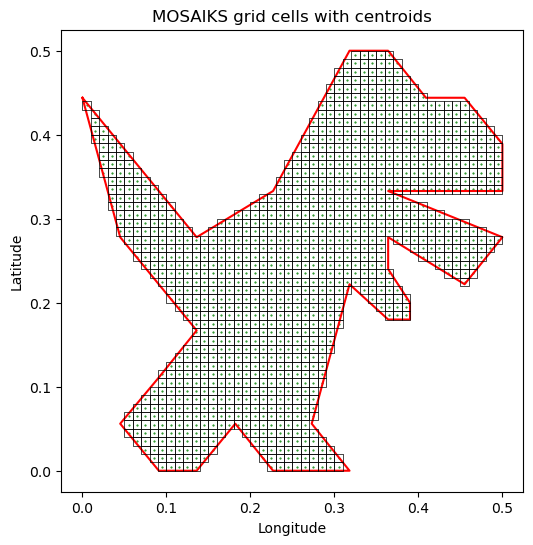

In [46]:
dino_grid_gdf = gpd.GeoDataFrame(
    dino_grid_df,
    geometry=gpd.points_from_xy(dino_grid_df.lon, dino_grid_df.lat),
    crs="EPSG:4326",
)
dino_grid_gdf.geometry = dino_grid_gdf.geometry.buffer(0.005, cap_style=3)

fig, ax = plt.subplots(figsize=(6, 6))

x, y = dino_polygon.exterior.xy
ax.plot(x, y, color="red")

dino_grid_gdf.plot.scatter(x="lon", y="lat", s=0.25, c="green", ax=ax)

dino_grid_gdf.boundary.plot(ax=ax, color="black", linewidth=0.5)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.title("MOSAIKS grid cells with centroids")
plt.show()

### Create a grid for a GeoDataFrame

#### Download the ADM0 dataset

In the following example, we create a grid for a GeoDataFrame with a geometry column. The grid will be created for the bounding box of each row, and then cropped to the geometry of that row. First, we load an example of a GeoDataFrame with a geometry column, two countries in this case. We then create a grid for each country and visualize the grid for each country.

This is slightly more practical use case, as it allows for the creation of a grid for multiple locations at once, while still minimizing the number of grid points that are created.


In [144]:
base_url = "https://github.com/wmgeolab/geoBoundaries/raw/9469f09/releaseData/gbOpen"

tgo_adm1_fp = f"{base_url}/TGO/ADM0/geoBoundaries-TGO-ADM0.geojson"

tgo_gdf = gpd.read_file(tgo_adm1_fp)

tgo_gdf[["shapeType", "shapeISO", "shapeName", "geometry"]]

,shapeType,shapeISO,shapeName,geometry
0,ADM0,TGO,Togo,"POLYGON ((-0.12366 11.137, -0.1309 11.13846, -..."


#### Create the grid for Togo


In [145]:
tgo_grid = create_grid(
    tgo_gdf,
    resolution=0.01,
    geometry_col="geometry",
    id_col="shapeISO",
    return_ids=True,
)
tgo_grid_gdf = gpd.GeoDataFrame(
    tgo_grid,
    geometry=gpd.points_from_xy(tgo_grid.lon, tgo_grid.lat),
    crs="EPSG:4326",
)
tgo_grid_gdf.geometry = tgo_grid_gdf.geometry.buffer(0.005, cap_style=3)

print(f"Shape (row, col): {tgo_grid_gdf.shape}")

tgo_grid_gdf.head()

C:\Users\Cullen\AppData\Local\Temp\ipykernel_30100\512871855.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  tgo_grid_gdf.geometry = tgo_grid_gdf.geometry.buffer(0.005, cap_style=3)


Shape (row, col): (46599, 5)


,lat,lon,shapeISO,unique_id,geometry
0,11.135,-0.125,TGO,lon_-0.125__lat_11.135,"POLYGON ((-0.12 11.14, -0.12 11.13, -0.13 11.1..."
1,11.135,-0.115,TGO,lon_-0.115__lat_11.135,"POLYGON ((-0.11 11.14, -0.11 11.13, -0.12 11.1..."
2,11.125,-0.135,TGO,lon_-0.135__lat_11.125,"POLYGON ((-0.13 11.13, -0.13 11.12, -0.14 11.1..."
3,11.125,-0.125,TGO,lon_-0.125__lat_11.125,"POLYGON ((-0.12 11.13, -0.12 11.12, -0.13 11.1..."
4,11.125,-0.115,TGO,lon_-0.115__lat_11.125,"POLYGON ((-0.11 11.13, -0.11 11.12, -0.12 11.1..."


#### Visualize the grids

Here we visualize our grids over the countries. Notice how the definition of the grid cells is lost as we zoom out. It is important to note that the maximum number of locations you can request via the MOSAIKS API is 100,000. In this case, it would be prudent to save a file for each country and upload them separately in 2 file queries.


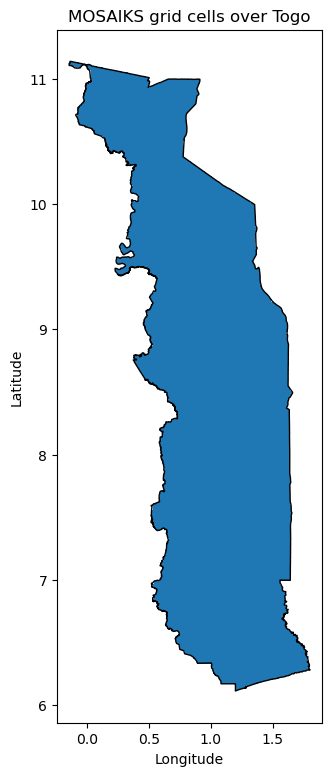

In [146]:
fig, ax = plt.subplots(figsize=(5, 9))

tgo_gdf.boundary.plot(
    ax=ax,
    color="black",
    linewidth=1,
)

tgo_grid_gdf.plot(
    ax=ax,
    legend=True,
    linewidth=0.0001,
)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.title("MOSAIKS grid cells over Togo")
plt.show()

### Area of each grid cell

Because our grid cells are defined in degrees, their actual area varies by latitude. Near the equator, each cell is approximately 1 km², while at higher latitudes the area decreases as the distance between meridians (longitude lines) converges. Below is a step-by-step outline for calculating and visualizing these differences:

1. Project and Calculate the Area

   - Convert the geometry to a projected Coordinate Reference System (CRS) with meters as the unit. Calculate the area of each grid cell (in m²), then convert to km².

1. Extract and Round Latitude

   - Create a new column containing the latitude of each grid cell, rounded to the nearest degree.

1. Visualize with a Boxplot
   - Group the data by rounded latitude (y-axis) and plot the corresponding area (x-axis) as a boxplot.

From the resulting plot, you’ll see that the cells near the equator maintain an area close to 1 km², but moving toward the poles reveals smaller areas due to the convergence of longitude lines.

This distinction is particularly important in the context of MOSAIKS when aggregating these grid-based estimates to larger areas (e.g., administrative polygons). This is why the API offers pre-aggregated features that apply area weighting or population weighting to ensure that each cell’s contribution is accurately reflected. This helps account for the smaller physical footprint of cells at higher latitudes, preventing potential biases in the aggregated results. We will look at this in more detail later in this notebook.


C:\Users\Cullen\AppData\Local\Temp\ipykernel_30100\2263000624.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


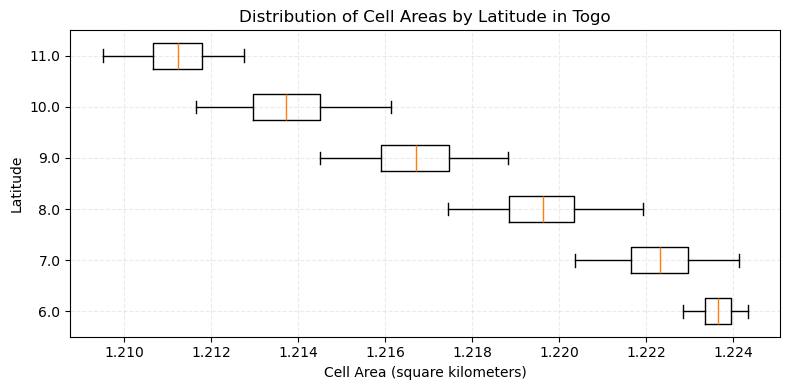

In [147]:
tgo_grid_gdf["cell_area"] = tgo_grid_gdf.to_crs("EPSG:32631").area / 10**6

tgo_grid_gdf["lat_rounded"] = tgo_grid_gdf["lat"].round(0)

plt.figure(figsize=(8, 4))

latitudes = sorted(tgo_grid_gdf["lat_rounded"].unique())

plt.boxplot(
    [tgo_grid_gdf.query("lat_rounded == @lat")["cell_area"] for lat in latitudes],
    labels=latitudes,
    vert=False,
)

plt.ylabel("Latitude")
plt.xlabel("Cell Area (square kilometers)")
plt.title("Distribution of Cell Areas by Latitude in Togo")
plt.grid(True, linestyle="--", alpha=0.25)

plt.tight_layout()
plt.show()

## Sticking with the grid - preparing labels

For the purposes of this demonstration, we will take advantage of the standardized grid and match our labels to this resolution. This is recommended for the most efficient use of the MOSAIKS API file query.

> There is no strict requirement to use this or any other grid system within the MOSAIKS framework. Using a different system may require the user to compute their own features.

Here we show how to match labels to the MOSAIKS grid.

**Note:** Later we will see examples of label aggregation to larger administrative boundaries.


### Data download

To faciliate using real world data, we will download geographic features in Togo from Open Street Map, provided by [Geofabrik](https://download.geofabrik.de/africa/togo.html).
We will show examples of how to match labels to the MOSAIKS grid for 4 different types of data:

| Example | Type           | Description                                          | File format      |
| ------- | -------------- | ---------------------------------------------------- | ---------------- |
| 1       | Point labels   | Geographic points of interest (bank, school, etc)    | Shapefile (.shp) |
| 2       | Line labels    | Geographic lines (roads, railways, etc)              | Shapefile (.shp) |
| 3       | Polygon labels | Geographic polygons (land use, bodies of water, etc) | Shapefile (.shp) |
| 4       | Raster labels  | Raster data (tree cover (%)) at 70 m resolution      | GeoTIFF (.tif)   |

This data contains many different types of geographic features, including points, lines, and polygons. We will use this data to demonstrate how to match labels to the MOSAIKS grid. A full description of the data and all variables can be found in the [Geofabrik documentation](https://download.geofabrik.de/osm-data-in-gis-formats-free.pdf).


In [148]:
data_dir = "geofabrik"

file = "https://download.geofabrik.de/africa/togo-latest-free.shp.zip"

if not os.path.exists(data_dir):
    os.makedirs(data_dir, exist_ok=True)

    !wget -O {data_dir}/togo-latest-free.zip {file}

    !unzip {data_dir}/togo-latest-free.zip -d {data_dir}

    # !rm {data_dir}/togo-latest-free.zip

# !ls -lhR {data_dir}

### Example 1: Points of interest

#### Scenario

You have a Shapefile (.shp) containing points of interest in your country. These data come as geographic cordinates (latitude, longitude) and a variable called `fclass` (feature class) that has values like `police`, `fire_station`, `park`, `bank`, and many more. The goal of this scenario is to match the points to the MOSAIKS grid and to save a clean file to your Google Drive.

#### Load the data

First, we load the points of interest (pois) data into a GeoDataFrame. We will use the `geopandas` library to load the shapefile `gis_osm_pois_free_1.shp`.


In [149]:
pois_fn = "gis_osm_pois_free_1.shp"

tgo_pois_gdf = gpd.read_file(os.path.join(data_dir, pois_fn))

# tgo_pois_gdf = tgo_pois_gdf[tgo_pois_gdf["fclass"].isin(["school"])]

print(f"Object type: {type(tgo_pois_gdf)}")

print(f"Shape (row, col): {tgo_pois_gdf.shape}")

tgo_pois_gdf.head()

Object type: <class 'geopandas.geodataframe.GeoDataFrame'>
Shape (row, col): (16197, 5)


,osm_id,code,fclass,name,geometry
0,533752458,2721,attraction,Wli Falls - Upper Falls,POINT (0.60972 7.1058)
1,620758476,2305,bar,None,POINT (0.46957 10.35178)
2,620950505,2401,hotel,Hôtel Central,POINT (1.13578 8.97307)
3,631710582,2952,water_tower,None,POINT (1.21227 6.18468)
4,631737244,2099,public_building,Direction Générale des Douanes,POINT (1.21528 6.12537)


#### Match the labels to the grid

Next, we match the labels to the grid. We use the `geopandas.sjoin` function to match the labels to the grid.


In [150]:
# First, perform spatial join between the grid and POIs
pois_grid = gpd.sjoin(
    tgo_grid_gdf,
    tgo_pois_gdf,
    how="left",
    predicate="contains",
)


#### Create label summaries

We then group the labels by the grid cell and count the number of labels in each grid cell. This will be our label summary.


In [151]:
# Group by grid cell (using lat/lon) and fclass, then count
pois_grid_count = pois_grid.groupby(
    ["lat", "lon", "cell_area", "unique_id"],
    as_index=False,
).fclass.count()

# Rename the fclass column
pois_grid_count = pois_grid_count.rename(columns={"fclass": "poi_count"})

pois_grid_count = gpd.GeoDataFrame(
    pois_grid_count,
    geometry=gpd.points_from_xy(pois_grid_count.lon, pois_grid_count.lat),
    crs="EPSG:4326",
)
pois_grid_count.geometry = pois_grid_count.geometry.buffer(0.005, cap_style=3)
pois_grid_count

C:\Users\Cullen\AppData\Local\Temp\ipykernel_30100\1630893445.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  pois_grid_count.geometry = pois_grid_count.geometry.buffer(0.005, cap_style=3)


,lat,lon,cell_area,unique_id,poi_count,geometry
0,6.115,1.205,1.224306,lon_1.205__lat_6.115,44,"POLYGON ((1.21 6.12, 1.21 6.11, 1.2 6.11, 1.2 ..."
1,6.125,1.205,1.224284,lon_1.205__lat_6.125,176,"POLYGON ((1.21 6.13, 1.21 6.12, 1.2 6.12, 1.2 ..."
2,6.125,1.215,1.224270,lon_1.215__lat_6.125,120,"POLYGON ((1.22 6.13, 1.22 6.12, 1.21 6.12, 1.2..."
3,6.125,1.225,1.224257,lon_1.225__lat_6.125,63,"POLYGON ((1.23 6.13, 1.23 6.12, 1.22 6.12, 1.2..."
4,6.125,1.235,1.224244,lon_1.235__lat_6.125,22,"POLYGON ((1.24 6.13, 1.24 6.12, 1.23 6.12, 1.2..."
...,...,...,...,...,...,...
46594,11.125,-0.085,1.210811,lon_-0.085__lat_11.125,0,"POLYGON ((-0.08 11.13, -0.08 11.12, -0.09 11.1..."
46595,11.125,-0.075,1.210789,lon_-0.075__lat_11.125,3,"POLYGON ((-0.07 11.13, -0.07 11.12, -0.08 11.1..."
46596,11.125,-0.065,1.210767,lon_-0.065__lat_11.125,4,"POLYGON ((-0.06 11.13, -0.06 11.12, -0.07 11.1..."
46597,11.135,-0.125,1.210859,lon_-0.125__lat_11.135,0,"POLYGON ((-0.12 11.14, -0.12 11.13, -0.13 11.1..."


#### Visualize the label summaries

Finally, we visualize the label summaries. We plot the grid cells and color them by the number of labels in each cell. This will give us a sense of the distribution of labels across the country.


<Axes: >

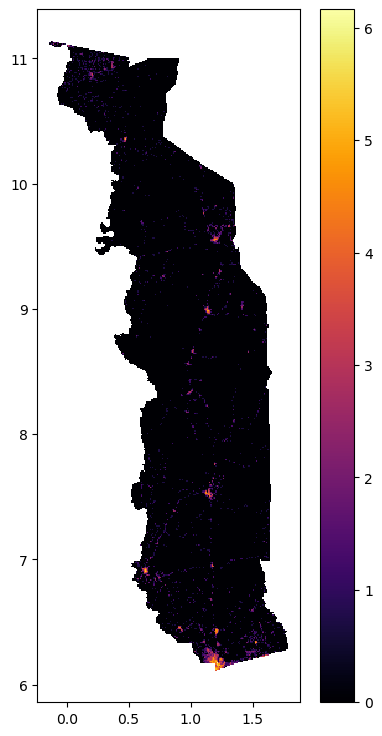

In [ ]:
pois_grid_count_log = pois_grid_count.copy()
pois_grid_count_log["poi_count"] = np.log1p(pois_grid_count["poi_count"])
pois_grid_count_log.plot(
    column="poi_count", legend=True, figsize=(5, 9), cmap="inferno"
)

In [17]:
# pois_grid_count.explore()

### Example 2: Waterway lines

#### Scenario

You have a Shapefile (.shp) containing line geometries of waterways in your country. The line geometry runs through the middle of the river in the direction of the water flow. These data come with a variable called `fclass` (feature class) that has values `stream`, `array`, `canal`, & `drain`. The goal of this scenario is to match the lines to the MOSAIKS grid and then summarise the length of each `fclass` value in each grid cell. We then make sure that we have a value for each grid cell (this includes many 0's). Finally we save a clean file to Google Drive.

#### Load the data

First, we load the points of waterways data into a GeoDataFrame. We will use the `geopandas` library to load the shapefile `gis_osm_waterways_free_1.shp`.


In [18]:
waterways_fn = "gis_osm_waterways_free_1.shp"

togo_waterways_gdf = gpd.read_file(os.path.join(data_dir, waterways_fn))

print(f"Object type: {type(togo_waterways_gdf)}")

print(f"Shape (row, col): {togo_waterways_gdf.shape}")

print(f"CRS: {togo_waterways_gdf.crs}")

togo_waterways_gdf.head()

Object type: <class 'geopandas.geodataframe.GeoDataFrame'>
Shape (row, col): (5153, 6)
CRS: EPSG:4326


,osm_id,code,fclass,width,name,geometry
0,30910268,8102,stream,0,Adjiro,"LINESTRING (1.61929 9.03397, 1.61931 9.03386, ..."
1,37284170,8101,river,0,None,"LINESTRING (0.07895 10.86995, 0.07829 10.87026..."
2,37284238,8101,river,0,None,"LINESTRING (-0.02318 10.82574, -0.02352 10.824..."
3,37284239,8102,stream,0,None,"LINESTRING (0.13294 10.9192, 0.13257 10.91939,..."
4,37284245,8102,stream,0,None,"LINESTRING (0.13831 11.01998, 0.13805 11.02023..."


Visualize the waterways data.


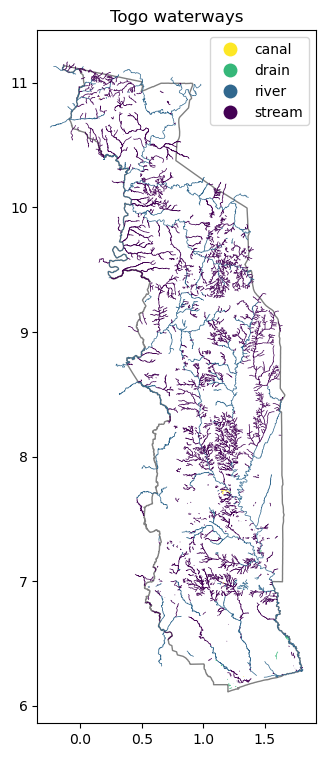

In [19]:
fig, ax = plt.subplots(figsize=(5, 9))

tgo_gdf.plot(
    ax=ax,
    color="none",
    edgecolor="grey",
    linewidth=1,
)

togo_waterways_gdf.plot(
    ax=ax,
    column="fclass",
    legend=True,
    linewidth=0.5,
    cmap="viridis_r",
)

plt.title("Togo waterways")

plt.show()

#### Match labels to the grid

To match these labels to the grid and get an appropriate summary we will take the following steps:

1. First, we match the labels to the grid. We use the `geopandas.overlay` function to match the labels to the grid with a spatial intersection.

1. Our data is currently in a geographic CRS, so we need to reproject it to a projected CRS before we can calculate the length of the lines. We use the `geopandas.to_crs` function to reproject the data to the `EPSG:32631` CRS, which is UTM Zone 31N projection which covers the region and has units in meters.

1. We then use the `GeDataFrame.geometry.length` function to calculate the length of each line in meters.

1. We also need to reproject the grid to the same CRS as the labels to calculate the area of the grid cells in square meters. We use the `geopandas.to_crs` function to reproject the grid to the `EPSG:32631` CRS.

1. We then create a dictionary of the grid cell areas that is indexed by latitude and longitude for easy look up

1. We now calculate the sum of the waterway lengths for each grid cell and `fclass` value.

1. We then divide the sum of the waterway lengths by the area of the grid cell to get the length of waterways per square meter in each grid cell. This operation becomes more important in larger geographic areas with greater distortion in the MOSAIKS grid.

1. We then do some data cleanup and join the result to the grid and fill in any missing values (locations that did not have waterways of certain types) with 0.


In [20]:
# 1. Perform spatial join with intersection (while still in WGS84)
waterways_intersected = gpd.overlay(
    togo_waterways_gdf,
    tgo_grid_gdf,
    how="intersection",
)

# 2. Now project to UTM Zone 31N for accurate measurements
waterways_proj = waterways_intersected.to_crs("EPSG:32631")

# 3. Calculate length in meters for each segment
waterways_proj["length_m"] = waterways_proj.geometry.length

# 4. Calculate grid cell areas (need to project grid cells too)
tgo_grid_proj = tgo_grid_gdf.to_crs("EPSG:32631")
grid_areas = tgo_grid_proj.geometry.area  # in square meters

# 5. Create a dictionary of grid cell areas indexed by lat/lon for easy lookup
grid_areas_dict = dict(zip(zip(tgo_grid_proj.lat, tgo_grid_proj.lon), grid_areas))

# 6. Group by grid cell and fclass to get total lengths
length_by_grid_fclass = (
    waterways_proj.groupby(["lat", "lon", "fclass"])["length_m"].sum().reset_index()
)

# 7. Add area and calculate density
length_by_grid_fclass["grid_area"] = length_by_grid_fclass.apply(
    lambda row: grid_areas_dict[(row["lat"], row["lon"])], axis=1
)
length_by_grid_fclass["density_m_per_km2"] = (
    length_by_grid_fclass["length_m"] / length_by_grid_fclass["grid_area"]
) * 1_000_000  # Convert to km²

# 8. Create pivot table with densities and join back to grid and fill NaNs with 0
density_pivot = length_by_grid_fclass.pivot_table(
    index=["lat", "lon"],
    columns="fclass",
    values="density_m_per_km2",
    fill_value=0,
)

density_pivot = density_pivot.reset_index().rename_axis(None, axis=1)

waterway_length_grid = tgo_grid_gdf.merge(density_pivot, on=["lat", "lon"], how="left")

waterway_length_grid = waterway_length_grid.fillna(0)

waterway_columns = togo_waterways_gdf.fclass.unique().tolist()

waterway_length_grid["total_waterway_length"] = waterway_length_grid[
    waterway_columns
].sum(axis=1)

print(f"Shape (row, col): {waterway_length_grid.shape}")

waterway_length_grid[
    ["lat", "lon", "canal", "drain", "river", "stream", "total_waterway_length"]
].head()

Shape (row, col): (46599, 12)


,lat,lon,canal,drain,river,stream,total_waterway_length
0,11.135,-0.125,0.0,0.0,0.000000,0.000000,0.000000
1,11.135,-0.115,0.0,0.0,0.000000,71.293618,71.293618
2,11.125,-0.135,0.0,0.0,878.877676,277.894946,1156.772622
3,11.125,-0.125,0.0,0.0,0.000000,0.000000,0.000000
4,11.125,-0.115,0.0,0.0,0.000000,320.000599,320.000599


#### Visualize the summarized waterways data


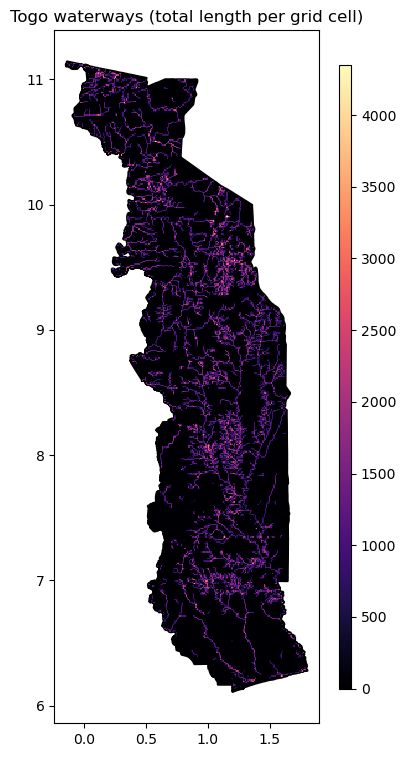

In [21]:
fig, ax = plt.subplots(figsize=(5, 9))

tgo_gdf.plot(
    ax=ax,
    color="none",
    edgecolor="black",
    linewidth=2,
)

waterway_length_grid.plot(
    ax=ax,
    column="total_waterway_length",
    legend=True,
    cmap="magma",
    legend_kwds={"shrink": 0.9, "aspect": 50},
)

plt.title("Togo waterways (total length per grid cell)")

plt.show()

### Example 3: Polygon Labels

#### Scenario

You have a Shapefile (.shp) containing polygons of land use in your country. We select the file containing the outlines of buildings. These data come with a variable called `fclass` (feature class) that are all labeled `building`. The various types of building are stored in the column `type` which contains values like `house`, `construction`, `hut`, `residential`, and many more. The goal of this scenario is to match the polygons to the MOSAIKS grid and then summarize the area of all buildings in each grid cell.

#### Load the data

First, we load the polygons of building footprints data into a GeoDataFrame. We will use the `geopandas` library to load the file `gis_osm_buildings_a_free_1.shp`.


In [22]:
buildings_fn = "gis_osm_buildings_a_free_1.shp"

togo_buildings_gdf = gpd.read_file(os.path.join(data_dir, buildings_fn))

print(f"Object type: {type(togo_buildings_gdf)}")

print(f"CRS: {togo_buildings_gdf.crs}")

print(f"Shape (row, col): {togo_buildings_gdf.shape}")

togo_buildings_gdf[["fclass", "type", "geometry"]].head()

Object type: <class 'geopandas.geodataframe.GeoDataFrame'>
CRS: EPSG:4326
Shape (row, col): (1471720, 6)


,fclass,type,geometry
0,building,hangar,"POLYGON ((1.09111 9.77964, 1.09113 9.77997, 1...."
1,building,None,"POLYGON ((1.23861 6.20216, 1.23862 6.2023, 1.2..."
2,building,church,"POLYGON ((1.21583 6.13581, 1.21588 6.13601, 1...."
3,building,None,"POLYGON ((1.16712 6.18699, 1.16725 6.18702, 1...."
4,building,None,"POLYGON ((1.16745 6.18593, 1.16762 6.18598, 1...."


#### Match labels to the grid

To match these labels to the grid and get an appropriate summary we will take the following steps:

1. Perform spatial join between buildings and grid cells

1. Reproject to an equal-area projection for accurate area calculations

1. Calculate building areas and group by grid cell

1. Calculate grid cell areas

1. Merge the building areas with the grid cells

1. Calculate coverage percentage

1. Fill NaN values (grid cells with no buildings) with 0


In [23]:
# 1. Perform spatial join between buildings and grid cells
buildings_in_cells = gpd.sjoin(
    togo_buildings_gdf, tgo_grid_gdf, how="inner", predicate="within"
)

# 2. Reproject to an equal-area projection for accurate area calculations
# Using UTM Zone 31N (EPSG:32631) which covers Togo
buildings_in_cells = buildings_in_cells.to_crs("EPSG:32631")
tgo_grid_projected = tgo_grid_gdf.to_crs("EPSG:32631")

# 3. Calculate building areas and group by grid cell
buildings_in_cells["building_area"] = buildings_in_cells.geometry.area
building_areas = (
    buildings_in_cells.groupby("index_right")["building_area"].sum().reset_index()
)

# 4. Calculate grid cell areas
tgo_grid_projected["cell_area"] = tgo_grid_projected.geometry.area

# 5. Merge the building areas with the grid cells
building_coverage_df = tgo_grid_projected.merge(
    building_areas, left_index=True, right_on="index_right", how="left"
)

# 6. Calculate coverage percentage
building_coverage_df["building_percent"] = (
    building_coverage_df["building_area"] / building_coverage_df["cell_area"]
) * 100

# 7. Fill NaN values (grid cells with no buildings) with 0
building_coverage_df["building_percent"] = building_coverage_df[
    "building_percent"
].fillna(0)

# View the results
building_coverage_df[
    ["lat", "lon", "building_area", "cell_area", "building_percent"]
].head()

,lat,lon,building_area,cell_area,building_percent
0.0,11.135,-0.125,853.815027,1.210859e+06,0.070513
1.0,11.135,-0.115,1976.132883,1.210836e+06,0.163204
2.0,11.125,-0.135,1097.193449,1.210922e+06,0.090608
3.0,11.125,-0.125,1056.235572,1.210900e+06,0.087227
4.0,11.125,-0.115,1029.739751,1.210877e+06,0.085041


#### Visualize the summarized building data


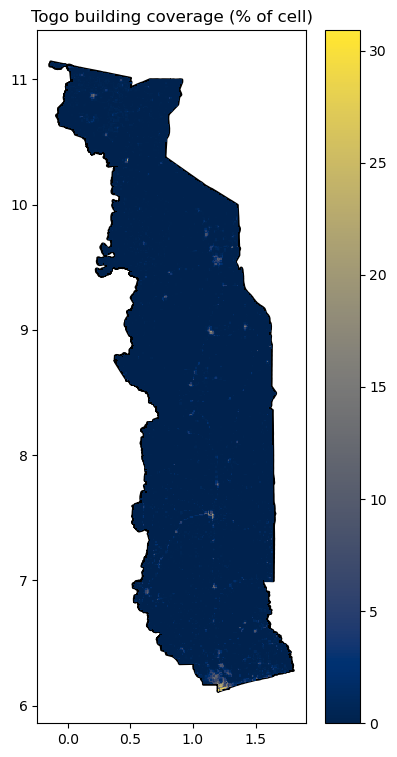

In [24]:
building_coverage_gdf = gpd.GeoDataFrame(
    building_coverage_df,
    geometry=gpd.points_from_xy(building_coverage_df.lon, building_coverage_df.lat),
    crs="EPSG:32631",
)
building_coverage_gdf.geometry = building_coverage_gdf.geometry.buffer(
    0.005, cap_style=3
)

fig, ax = plt.subplots(figsize=(5, 9))

tgo_gdf.plot(
    ax=ax,
    color="none",
    edgecolor="black",
    linewidth=2,
)

building_coverage_gdf.plot(
    ax=ax,
    column="building_percent",
    legend=True,
    cmap="cividis",
)

plt.title("Togo building coverage (% of cell)")

plt.show()

### Example 4: Raster Labels

#### Scenario

You have a GeoTIFF file containing raster data of tree cover percentage in your country. The goal of this scenario is to match the raster data to the MOSAIKS grid and then summarize the tree cover percentage in each grid cell.

#### Load the data

We will use the [Global Forest Watch](https://www.globalforestwatch.org/) dataset for [tropical tree cover](https://data.globalforestwatch.org/datasets/gfw::tropical-tree-cover/about). The code uses the `half_hectare_download` which provides tree cover percentage at half hectare resolution (~70 m). We will use the GFW API and their public key to download the data. to get full coverage of the country, we will download the data from the 3 tiles which overlap with Togo.


In [25]:
# Define target folder and ensure it exists
gw_folder = "global_forest_watch/70m_tree-cover"
os.makedirs(gw_folder, exist_ok=True)

# Base URL for downloading the data
gfw_url = "https://data-api.globalforestwatch.org"
base_url = f"{gfw_url}/dataset/wri_tropical_tree_cover/v2020/download/geotiff"

# This is the default API key for the Global Forest Watch API (Public Key)
api_key = "2d60cd88-8348-4c0f-a6d5-bd9adb585a8c"

# List of tile IDs to download
tile_ids = ["20N_010W", "20N_000E", "10N_000E"]

# Loop through each tile ID and download
for tile_id in tile_ids:
    output_path = os.path.join(gw_folder, f"{tile_id}.tif")

    if os.path.exists(output_path):
        print(f"{tile_id} already exists. Skipping...")
        continue

    params = (
        f"?grid=10/40000&tile_id={tile_id}&pixel_meaning=percent&x-api-key={api_key}"
    )
    url = f"{base_url}{params}"

    print(f"Downloading {tile_id}...")
    result = subprocess.run(
        ["wget", "-O", output_path, url], capture_output=True, text=True
    )

    # Check for errors
    if result.returncode == 0:
        print(f"Downloaded {tile_id} successfully to {output_path}")
    else:
        print(f"Error downloading {tile_id}: {result.stderr}")

20N_010W already exists. Skipping...
20N_000E already exists. Skipping...
10N_000E already exists. Skipping...


#### Crop the raster to the outline of Togo

Despite the low resolution, the raster data is still too large to hold all of it in memory on the free tier of Google Colab. Luckily, we do not need all of the data, only the data that overlaps with Togo. We will use the `rasterio.mask.mask` function to crop the raster data to the outline of Togo. We do this once for each file to keep under the memory limits. We then combine the data into a single raster and save a compressed version.


In [26]:
# Step 1: Load the Togo boundary GeoDataFrame and extract the geometry
tgo_gdf = gpd.read_file(tgo_adm1_fp)
togo_boundary = [tgo_gdf.geometry.values[0]]  # Ensure it's a list of geometries

# Folder and output paths
gw_files = ["10N_000E.tif", "20N_000E.tif", "20N_010W.tif"]
out_raster = os.path.join(gw_folder, "togo_gfw_tropical_tree_cover_2020.tif")

# Step 2: Read, crop, and store rasters in memory
memory_files = []
for raster_file in gw_files:
    raster_path = os.path.join(gw_folder, raster_file)
    with rasterio.open(raster_path) as src:
        # Clip raster with the Togo boundary
        out_image, out_transform = mask(src, togo_boundary, crop=True)
        out_meta = src.meta.copy()

        # Update metadata for cropped raster
        out_meta.update(
            {
                "driver": "GTiff",
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform,
            }
        )

        # Write to a MemoryFile
        memfile = MemoryFile()
        with memfile.open(**out_meta) as dataset:
            dataset.write(out_image)
        memory_files.append(memfile)

# Step 3: Merge all cropped rasters into one
datasets = [memfile.open() for memfile in memory_files]
merged_data, merged_transform = merge(datasets)

# Modify values outside 0 and 100 to NaN
merged_data = merged_data.astype("float32")  # Ensure the data type supports NaN
merged_data[(merged_data < 0) | (merged_data > 100)] = np.nan

# Step 4: Write the final merged raster to file with compression
with rasterio.open(
    out_raster,
    "w",
    driver="GTiff",
    height=merged_data.shape[1],
    width=merged_data.shape[2],
    count=merged_data.shape[0],
    dtype="float32",  # Ensure dtype matches merged_data
    crs=src.crs,
    transform=merged_transform,
    tiled=True,  # Enable tiling
    blockxsize=512,  # Set block size for optimal tiling
    blockysize=512,
    compress="lzw",  # Apply LZW compression
    nodata=np.nan,  # Set nodata value explicitly
) as dst:
    dst.write(merged_data)

print(f"Clipped, modified, and merged raster saved to: {out_raster}")

Clipped, modified, and merged raster saved to: global_forest_watch/70m_tree-cover\togo_gfw_tropical_tree_cover_2020.tif


#### Visualize the forest cover data

Next we load in the cropped raster data and visualize it. We use the `rasterio.plot.show` function to visualize the raster data. We see that the data is in a raster format, with each pixel representing the tree cover percentage in that area.


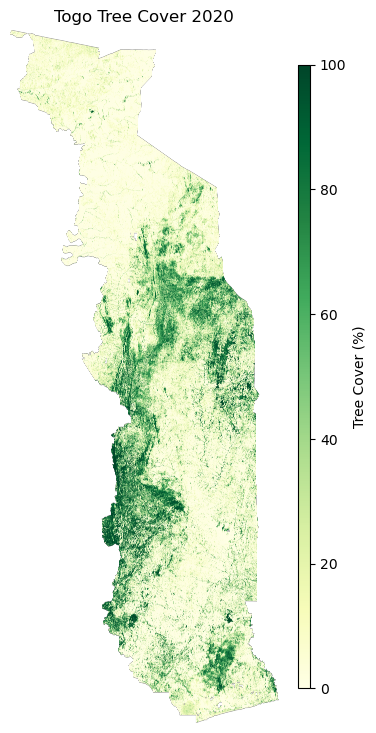

In [27]:
forest_cover_raster = f"{gw_folder}/togo_gfw_tropical_tree_cover_2020.tif"

with rasterio.open(forest_cover_raster) as src:
    togo_gfw = src.read(1)

fig, ax = plt.subplots(figsize=(5, 9))

im = ax.imshow(togo_gfw, cmap="YlGn")

plt.colorbar(im, label="Tree Cover (%)", shrink=0.9, aspect=50)

ax.set_title("Togo Tree Cover 2020")

ax.set_axis_off()

plt.show()

#### Match labels to the grid

To match these labels to the grid we will take the following steps:

1. Load the cropped raster data

1. Use the `exactextract.exact_extract` function to get the mean, median, min, and max tree cover percentages for each grid cell

1. Make the extracted data into a `geopandas.GeoDataFrame` and rename the columns


In [28]:
# Load the cropped file
with rasterio.open(forest_cover_raster) as src:
    # extract the raster values to the grid cells
    tree_cover_grid = exact_extract(
        src,
        tgo_grid_gdf,
        ["mean", "median", "min", "max"],
        include_cols=["lat", "lon"],
        output="pandas",
    )

# Make the extracted values into a GeoDataFrame
tree_cover_grid = gpd.GeoDataFrame(
    tree_cover_grid,
    geometry=gpd.points_from_xy(tree_cover_grid.lon, tree_cover_grid.lat),
    crs="EPSG:4326",
)

# Buffer the points to create a small rectangular polygon around each point
tree_cover_grid.geometry = tree_cover_grid.geometry.buffer(0.005, cap_style=3)

tree_cover_grid = tree_cover_grid.rename(
    columns={
        "mean": "tree_cover_mean",
        "median": "tree_cover_median",
        "min": "tree_cover_min",
        "max": "tree_cover_max",
    }
)
tree_cover_grid.head()

c:\Users\Cullen\anaconda3\envs\mosaiks\Lib\site-packages\exactextract\exact_extract.py:330: RuntimeWarning: Spatial reference system of input features does not exactly match raster.
  warnings.warn(
C:\Users\Cullen\AppData\Local\Temp\ipykernel_30100\1636522784.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  tree_cover_grid.geometry = tree_cover_grid.geometry.buffer(0.005, cap_style=3)


,lat,lon,tree_cover_mean,tree_cover_median,tree_cover_min,tree_cover_max,geometry
0,11.135,-0.125,3.667526,2.000410,0.0,49.0,"POLYGON ((-0.12 11.14, -0.12 11.13, -0.13 11.1..."
1,11.135,-0.115,1.814947,0.862341,0.0,20.0,"POLYGON ((-0.11 11.14, -0.11 11.13, -0.12 11.1..."
2,11.125,-0.135,7.618785,5.497153,0.0,49.0,"POLYGON ((-0.13 11.13, -0.13 11.12, -0.14 11.1..."
3,11.125,-0.125,7.797500,6.603594,0.0,49.0,"POLYGON ((-0.12 11.13, -0.12 11.12, -0.13 11.1..."
4,11.125,-0.115,9.183750,5.721409,0.0,60.0,"POLYGON ((-0.11 11.13, -0.11 11.12, -0.12 11.1..."


#### Visualize the extracted data

Now we visualize the extracted data. We use the `geopandas.GeoDataFrame.plot` function. You can change the `column` parameter to visualize different statistics.


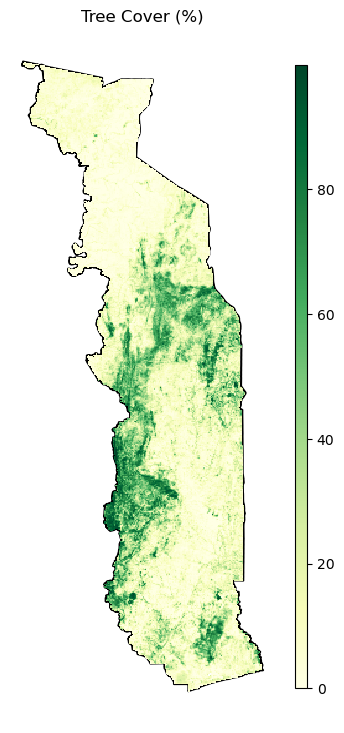

In [29]:
fig, ax = plt.subplots(figsize=(5, 9))

tgo_gdf.plot(
    ax=ax,
    color="none",
    edgecolor="black",
    linewidth=1.5,
)

tree_cover_grid.plot(
    ax=ax,
    column="tree_cover_mean",
    legend=True,
    cmap="YlGn",
    legend_kwds={"shrink": 0.9, "aspect": 50},
)

plt.axis("off")

plt.title("Tree Cover (%)")

plt.show()

## Combine all labels

Now that we have prepared all of our labels, we can combine them into a single DataFrame. This way we will have a single file with the following structure:

| Data type | Column names                                                               |
| --------- | -------------------------------------------------------------------------- |
| Coords    | `latitude`, `longitude`, `cell_area`                                       |
| Points    | `poi_count`                                                                |
| Lines     | `canal`, `drain`, `river`, `stream`, `total_waterway_length`               |
| Polygons  | `building_area`, `building_percent`                                        |
| Rasters   | `tree_cover_mean`, `tree_cover_median`, `tree_cover_min`, `tree_cover_max` |

This represents a single file with 12 different variables that can be used to build MOSAIKS models from 4 distinct geographic data types.


In [30]:
pois_grid_count = pois_grid_count.drop(columns=["geometry"], errors="ignore")

waterway_length_grid = waterway_length_grid.drop(
    columns=["shapeISO", "cell_area", "lat_rounded", "geometry", "unique_id"],
    errors="ignore",
)

building_coverage_df = building_coverage_df.drop(
    columns=[
        "shapeISO",
        "geometry",
        "cell_area",
        "lat_rounded",
        "index_right",
        "unique_id",
    ],
    errors="ignore",
)

tree_cover_grid = tree_cover_grid.drop(columns=["geometry"], errors="ignore")

# Merge pois_grid_count and waterway_length_grid
df_merged = pd.merge(
    pois_grid_count,
    waterway_length_grid,
    on=["lat", "lon"],
    how="outer",
)

# Then merge building_coverage_df
df_merged = pd.merge(df_merged, building_coverage_df, on=["lat", "lon"], how="outer")

# Finally, merge tree_cover_grid
df_merged = pd.merge(df_merged, tree_cover_grid, on=["lat", "lon"], how="outer")

print(f"Shape (row, col): {df_merged.shape}")

df_merged.head()

Shape (row, col): (46599, 16)


,lat,lon,cell_area,unique_id,poi_count,canal,drain,river,stream,total_waterway_length,building_area,building_percent,tree_cover_mean,tree_cover_median,tree_cover_min,tree_cover_max
0,6.115,1.205,1.224306,lon_1.205__lat_6.115,44,0.0,0.0,0.0,0.0,0.0,163556.495671,13.359120,3.384615,1.082665,0.0,49.0
1,6.125,1.205,1.224284,lon_1.205__lat_6.125,176,0.0,0.0,0.0,0.0,0.0,355572.394740,29.043305,3.140625,1.345668,0.0,63.0
2,6.125,1.215,1.224270,lon_1.215__lat_6.125,120,0.0,0.0,0.0,0.0,0.0,164009.596774,13.396519,31.725000,26.686207,0.0,98.0
3,6.125,1.225,1.224257,lon_1.225__lat_6.125,63,0.0,0.0,0.0,0.0,0.0,287367.464921,23.472805,2.328380,0.765228,0.0,34.0
4,6.125,1.235,1.224244,lon_1.235__lat_6.125,22,0.0,0.0,0.0,0.0,0.0,71933.470694,5.875747,5.071429,0.960378,0.0,58.0


### Save the combined labels

Finally, we save the combined labels to a `feather` file in Google Drive. Feather is a fast, lightweight, and easy-to-use binary file format for storing data frames. It is particularly useful for sharing data between languages like Python and R. Pandas has built in support for reading and writing feather files with the `pd.read_feather` and `pd.to_feather` functions.

This step is optional, but we will use these later in the training manual to build models. If you would prefer to skip this step, there will be a link to download the file in those later notebooks, just as we downloaded data in this notebook.

If you prefer to use your own data, we need to connect to Google Drive. We will use the `google.colab` library to do this. Just set the `save_to_drive` variable to `True` and run the cell. You will be prompted to authenticate with your Google account and give the notebook permission to access your Google Drive. Once you have done this, the file will be saved to your Google Drive.

**Note:** If you are using this notebook in a language other than English, you may need to adjust the file path defined by `drive_directory` to match the name of the folder where you want to save the file in your Google Drive.


In [ ]:
save_to_drive = False

if save_to_drive:
    from google.colab import drive

    drive_dir = "/content/drive"

    drive.mount(drive_dir)

    drive_directory = os.path.join(
        drive_dir,
        "MyDrive",
        "Colab Notebooks",
        "Data",
    )

    os.makedirs(drive_directory, exist_ok=True)

    file_path = os.path.join(drive_directory, "togo_geospatial_data.feather")

    df_merged.to_feather(file_path)

## Aggregating labels to lower resolutions

Some users may want to take advantage of precomputed feature aggregations that are available on the API. These precomputed files come in 0.1 degree or 1 degree grids or summarized to three levels of administrative division (ADM0 - Country, ADM1 - state/province, & ADM2 - county/district).

- Reduce the number of labels (pros and cons)
- Reduce noise in the data
- Increase the interpretability of the data
- Not everything needs high resolution data
- Can be predicted at higher resolution (super resolution)
- Some data comes aggregated already

This section of the demonstration will cover the aggregation of labels to these lower resolutions. We will demonstrate this by utilizing the same datasets and variables from the previous section. Now, instead of summarizing the data to the MOSAIKS grid, we will make 2 distinct summaries:

1. To a larger grid (0.1 degree instead of 0.01 degree)

1. To the second level of subnational administrative divisions (ADM2)

### Aggregating to a larger grid

First we will aggregate the data to a larger grid size of 0.1 degrees. This will help reduce the number of labels. The smaller sample size also mean that we will require fewer features. With both datasets being significantly smaller, the models will be faster to train and the computational and storage requirements are reduced.

#### Make a 0.1 degree grid

First, we will make a 0.1 degree grid. We will use the same function as before, but change the resolution to 0.1 degrees.


In [127]:
tgo_buffer = tgo_gdf.copy()
tgo_buffer.geometry = tgo_buffer.geometry.buffer(0.1)

tgo_grid_big = create_grid(
    tgo_buffer,
    resolution=0.1,
    geometry_col="geometry",
    id_col="shapeISO",
    return_ids=True,
)
tgo_grid_big_gdf = gpd.GeoDataFrame(
    tgo_grid_big,
    geometry=gpd.points_from_xy(tgo_grid_big.lon, tgo_grid_big.lat),
    crs="EPSG:4326",
)
tgo_grid_big_gdf.geometry = tgo_grid_big_gdf.geometry.buffer(0.05, cap_style=3)

tgo_grid_big_gdf = tgo_grid_big_gdf[tgo_grid_big_gdf.intersects(tgo_gdf.unary_union)]

print(f"Shape (row, col): {tgo_grid_big_gdf.shape}")

tgo_grid_big_gdf.head()

C:\Users\Cullen\AppData\Local\Temp\ipykernel_30100\1121000680.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  tgo_buffer.geometry = tgo_buffer.geometry.buffer(0.1)


Shape (row, col): (547, 5)


C:\Users\Cullen\AppData\Local\Temp\ipykernel_30100\1121000680.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  tgo_grid_big_gdf.geometry = tgo_grid_big_gdf.geometry.buffer(0.05, cap_style=3)
C:\Users\Cullen\AppData\Local\Temp\ipykernel_30100\1121000680.py:18: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  tgo_grid_big_gdf = tgo_grid_big_gdf[tgo_grid_big_gdf.intersects(tgo_gdf.unary_union)]


,lat,lon,shapeISO,unique_id,geometry
15,11.095,-0.095,TGO,lon_-0.095__lat_11.095,"POLYGON ((-0.045 11.145, -0.045 11.045, -0.145..."
16,11.095,0.005,TGO,lon_0.005__lat_11.095,"POLYGON ((0.055 11.145, 0.055 11.045, -0.045 1..."
17,11.095,0.105,TGO,lon_0.105__lat_11.095,"POLYGON ((0.155 11.145, 0.155 11.045, 0.055 11..."
18,11.095,0.205,TGO,lon_0.205__lat_11.095,"POLYGON ((0.255 11.145, 0.255 11.045, 0.155 11..."
19,11.095,0.305,TGO,lon_0.305__lat_11.095,"POLYGON ((0.355 11.145, 0.355 11.045, 0.255 11..."


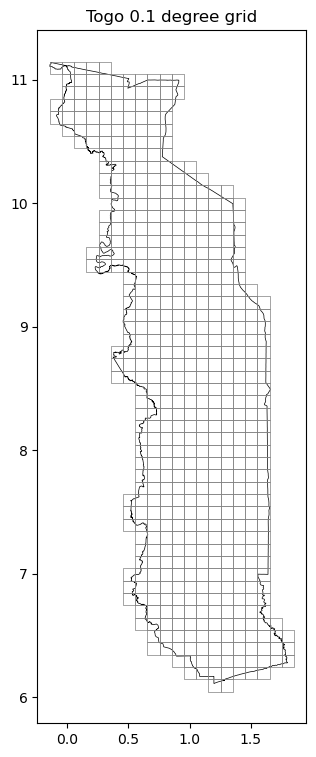

In [128]:
fig, ax = plt.subplots(figsize=(5, 9))

tgo_gdf.plot(
    ax=ax,
    color="none",
    edgecolor="black",
    linewidth=0.51,
)

tgo_grid_big_gdf.plot(
    ax=ax,
    color="none",
    edgecolor="grey",
    linewidth=0.5,
)

plt.title("Togo 0.1 degree grid")

plt.show()

### Example 1: Places of interest

#### Load the data


In [129]:
pois_fn = "gis_osm_pois_free_1.shp"

tgo_pois_gdf = gpd.read_file(os.path.join(data_dir, pois_fn))

# tgo_pois_gdf = tgo_pois_gdf[tgo_pois_gdf["fclass"].isin(["school"])]

print(f"Object type: {type(tgo_pois_gdf)}")

print(f"Shape (row, col): {tgo_pois_gdf.shape}")

tgo_pois_gdf.head()

Object type: <class 'geopandas.geodataframe.GeoDataFrame'>
Shape (row, col): (16197, 5)


,osm_id,code,fclass,name,geometry
0,533752458,2721,attraction,Wli Falls - Upper Falls,POINT (0.60972 7.1058)
1,620758476,2305,bar,None,POINT (0.46957 10.35178)
2,620950505,2401,hotel,Hôtel Central,POINT (1.13578 8.97307)
3,631710582,2952,water_tower,None,POINT (1.21227 6.18468)
4,631737244,2099,public_building,Direction Générale des Douanes,POINT (1.21528 6.12537)


In [132]:
# First, perform spatial join between the grid and POIs
pois_grid_big = gpd.sjoin(
    tgo_grid_big_gdf,
    tgo_pois_gdf,
    how="left",
    predicate="contains",
)

In [137]:
# Group by grid cell (using lat/lon) and fclass, then count
pois_grid_big_count = pois_grid_big.groupby(
    ["lat", "lon", "unique_id"],
    as_index=False,
).fclass.count()

# Rename the fclass column
pois_grid_big_count = pois_grid_big_count.rename(columns={"fclass": "poi_count"})

pois_grid_big_count = gpd.GeoDataFrame(
    pois_grid_big_count,
    geometry=gpd.points_from_xy(pois_grid_big_count.lon, pois_grid_big_count.lat),
    crs="EPSG:4326",
)
pois_grid_big_count.geometry = pois_grid_big_count.geometry.buffer(0.05, cap_style=3)

print(f"Shape (row, col): {pois_grid_big_count.shape}")

pois_grid_big_count.head()

Shape (row, col): (547, 5)


C:\Users\Cullen\AppData\Local\Temp\ipykernel_30100\2202245442.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  pois_grid_big_count.geometry = pois_grid_big_count.geometry.buffer(0.05, cap_style=3)


,lat,lon,unique_id,poi_count,geometry
0,6.095,1.205,lon_1.205__lat_6.095,1045,"POLYGON ((1.255 6.145, 1.255 6.045, 1.155 6.04..."
1,6.095,1.305,lon_1.305__lat_6.095,29,"POLYGON ((1.355 6.145, 1.355 6.045, 1.255 6.04..."
2,6.195,1.005,lon_1.005__lat_6.195,0,"POLYGON ((1.055 6.245, 1.055 6.145, 0.955 6.14..."
3,6.195,1.105,lon_1.105__lat_6.195,254,"POLYGON ((1.155 6.245, 1.155 6.145, 1.055 6.14..."
4,6.195,1.205,lon_1.205__lat_6.195,4618,"POLYGON ((1.255 6.245, 1.255 6.145, 1.155 6.14..."


<Axes: >

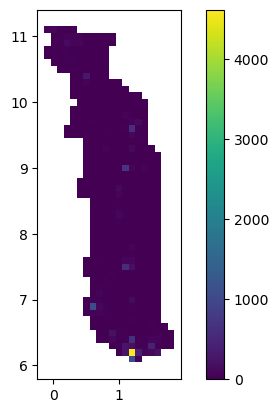

In [138]:
pois_grid_big_count.plot(column="poi_count", legend=True, cmap="viridis")

### Example 2: Waterways

#### Load the data


In [ ]:
# waterways_fn = "gis_osm_waterways_free_1.shp"

# togo_waterways_gdf = gpd.read_file(os.path.join(data_dir, waterways_fn))

# print(f"Object type: {type(togo_waterways_gdf)}")

# print(f"Shape (row, col): {togo_waterways_gdf.shape}")

# print(f"CRS: {togo_waterways_gdf.crs}")

# togo_waterways_gdf.head()

In [ ]:
# # 1. Perform spatial join with intersection (while still in WGS84)
# waterways_intersected = gpd.overlay(
#     togo_waterways_gdf,
#     tgo_grid_gdf,
#     how="intersection",
# )

# # 2. Now project to UTM Zone 31N for accurate measurements
# waterways_proj = waterways_intersected.to_crs("EPSG:32631")

# # 3. Calculate length in meters for each segment
# waterways_proj["length_m"] = waterways_proj.geometry.length

# # 4. Calculate grid cell areas (need to project grid cells too)
# tgo_grid_proj = tgo_grid_gdf.to_crs("EPSG:32631")
# grid_areas = tgo_grid_proj.geometry.area  # in square meters

# # 5. Create a dictionary of grid cell areas indexed by lat/lon for easy lookup
# grid_areas_dict = dict(zip(zip(tgo_grid_proj.lat, tgo_grid_proj.lon), grid_areas))

# # 6. Group by grid cell and fclass to get total lengths
# length_by_grid_fclass = (
#     waterways_proj.groupby(["lat", "lon", "fclass"])["length_m"].sum().reset_index()
# )

# # 7. Add area and calculate density
# length_by_grid_fclass["grid_area"] = length_by_grid_fclass.apply(
#     lambda row: grid_areas_dict[(row["lat"], row["lon"])], axis=1
# )
# length_by_grid_fclass["density_m_per_km2"] = (
#     length_by_grid_fclass["length_m"] / length_by_grid_fclass["grid_area"]
# ) * 1_000_000  # Convert to km²

# # 8. Create pivot table with densities and join back to grid and fill NaNs with 0
# density_pivot = length_by_grid_fclass.pivot_table(
#     index=["lat", "lon"],
#     columns="fclass",
#     values="density_m_per_km2",
#     fill_value=0,
# )

# density_pivot = density_pivot.reset_index().rename_axis(None, axis=1)

# waterway_length_grid = tgo_grid_gdf.merge(density_pivot, on=["lat", "lon"], how="left")

# waterway_length_grid = waterway_length_grid.fillna(0)

# waterway_columns = togo_waterways_gdf.fclass.unique().tolist()

# waterway_length_grid["total_waterway_length"] = waterway_length_grid[
#     waterway_columns
# ].sum(axis=1)

# print(f"Shape (row, col): {waterway_length_grid.shape}")

# waterway_length_grid[
#     ["lat", "lon", "canal", "drain", "river", "stream", "total_waterway_length"]
# ].head()

In [ ]:
# fig, ax = plt.subplots(figsize=(5, 9))

# tgo_gdf.plot(
#     ax=ax,
#     color="none",
#     edgecolor="black",
#     linewidth=2,
# )

# waterway_length_grid.plot(
#     ax=ax,
#     column="total_waterway_length",
#     legend=True,
#     cmap="magma",
#     legend_kwds={"shrink": 0.9, "aspect": 50},
# )

# plt.title("Togo waterways (total length per grid cell)")

# plt.show()

### Example 3: buildings

#### Load the data


In [ ]:
buildings_fn = "gis_osm_buildings_a_free_1.shp"

togo_buildings_gdf = gpd.read_file(os.path.join(data_dir, buildings_fn))

print(f"Object type: {type(togo_buildings_gdf)}")

print(f"CRS: {togo_buildings_gdf.crs}")

print(f"Shape (row, col): {togo_buildings_gdf.shape}")

togo_buildings_gdf[["fclass", "type", "geometry"]].head()

In [ ]:
# # 1. Perform spatial join between buildings and grid cells
# buildings_in_cells = gpd.sjoin(
#     togo_buildings_gdf, tgo_grid_gdf, how="inner", predicate="within"
# )

# # 2. Reproject to an equal-area projection for accurate area calculations
# # Using UTM Zone 31N (EPSG:32631) which covers Togo
# buildings_in_cells = buildings_in_cells.to_crs("EPSG:32631")
# tgo_grid_projected = tgo_grid_gdf.to_crs("EPSG:32631")

# # 3. Calculate building areas and group by grid cell
# buildings_in_cells["building_area"] = buildings_in_cells.geometry.area
# building_areas = (
#     buildings_in_cells.groupby("index_right")["building_area"].sum().reset_index()
# )

# # 4. Calculate grid cell areas
# tgo_grid_projected["cell_area"] = tgo_grid_projected.geometry.area

# # 5. Merge the building areas with the grid cells
# building_coverage_df = tgo_grid_projected.merge(
#     building_areas, left_index=True, right_on="index_right", how="left"
# )

# # 6. Calculate coverage percentage
# building_coverage_df["building_percent"] = (
#     building_coverage_df["building_area"] / building_coverage_df["cell_area"]
# ) * 100

# # 7. Fill NaN values (grid cells with no buildings) with 0
# building_coverage_df["building_percent"] = building_coverage_df[
#     "building_percent"
# ].fillna(0)

# # View the results
# building_coverage_df[
#     ["lat", "lon", "building_area", "cell_area", "building_percent"]
# ].head()

In [ ]:
# building_coverage_gdf = gpd.GeoDataFrame(
#     building_coverage_df,
#     geometry=gpd.points_from_xy(building_coverage_df.lon, building_coverage_df.lat),
#     crs="EPSG:32631",
# )
# building_coverage_gdf.geometry = building_coverage_gdf.geometry.buffer(
#     0.005, cap_style=3
# )

# fig, ax = plt.subplots(figsize=(5, 9))

# tgo_gdf.plot(
#     ax=ax,
#     color="none",
#     edgecolor="black",
#     linewidth=2,
# )

# building_coverage_gdf.plot(
#     ax=ax,
#     column="building_percent",
#     legend=True,
#     cmap="cividis",
# )

# plt.title("Togo building coverage (% of cell)")

# plt.show()

### Example 4: Tree cover

#### Load the data


In [155]:
# # Load the cropped file
# with rasterio.open(forest_cover_raster) as src:
#     # extract the raster values to the grid cells
#     tree_cover_grid = exact_extract(
#         src,
#         tgo_grid_gdf,
#         ["mean", "median", "min", "max"],
#         include_cols=["lat", "lon"],
#         output="pandas",
#     )

# # Make the extracted values into a GeoDataFrame
# tree_cover_grid = gpd.GeoDataFrame(
#     tree_cover_grid,
#     geometry=gpd.points_from_xy(tree_cover_grid.lon, tree_cover_grid.lat),
#     crs="EPSG:4326",
# )

# # Buffer the points to create a small rectangular polygon around each point
# tree_cover_grid.geometry = tree_cover_grid.geometry.buffer(0.005, cap_style=3)

# tree_cover_grid = tree_cover_grid.rename(
#     columns={
#         "mean": "tree_cover_mean",
#         "median": "tree_cover_median",
#         "min": "tree_cover_min",
#         "max": "tree_cover_max",
#     }
# )
# tree_cover_grid.head()

In [ ]:
# fig, ax = plt.subplots(figsize=(5, 9))

# tgo_gdf.plot(
#     ax=ax,
#     color="none",
#     edgecolor="black",
#     linewidth=1.5,
# )

# tree_cover_grid.plot(
#     ax=ax,
#     column="tree_cover_mean",
#     legend=True,
#     cmap="YlGn",
#     legend_kwds={"shrink": 0.9, "aspect": 50},
# )

# plt.axis("off")

# plt.title("Tree Cover (%)")

# plt.show()

### Aggregating to ADM2

This section will cover label aggregation to the second level of subnational administrative divisions (ADM2) in Togo.


### Download the ADM2 boundaries


In [161]:
tgo_adm2_fp = f"{base_url}/TGO/ADM2/geoBoundaries-TGO-ADM2.geojson"

tgo_gdf = gpd.read_file(tgo_adm2_fp)

tgo_gdf[["shapeType", "shapeGroup", "shapeName", "geometry"]].head()

,shapeType,shapeGroup,shapeName,geometry
0,ADM2,TGO,Tchamba,"POLYGON ((1.6215 8.36596, 1.61974 8.3741, 1.62..."
1,ADM2,TGO,Tchaoudjo,"POLYGON ((1.45008 9.27894, 1.44741 9.28273, 1...."
2,ADM2,TGO,Assoli,"POLYGON ((1.43123 9.29781, 1.42092 9.30743, 1...."
3,ADM2,TGO,Binah,"POLYGON ((1.36239 9.48598, 1.36109 9.48638, 1...."
4,ADM2,TGO,Doufelgou,"POLYGON ((1.35872 9.91389, 1.35861 9.91631, 1...."


<Axes: >

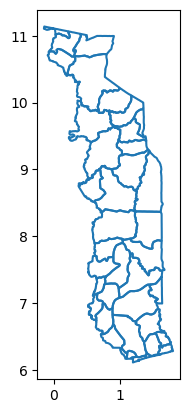

In [159]:
tgo_gdf.boundary.plot()

## Summary

The data we downloaded from Geofabrik contains many more files that we did not use. Take a look at the [Geofabrik documentation](https://download.geofabrik.de/osm-data-in-gis-formats-free.pdf) to see what other data is available. You can use the same workflows that we used in this notebook, though some further modifications may be necessary depending on the data you are working with.

We hope that these examples serve as a useful guide on how to think about label data and prepare labels for use in MOSAIKS. One of the hardest parts of data science is getting the data into the right format.
